In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
from astropy.io import fits
from astropy.table import QTable, Column
import astropy.units as u
from scipy.optimize import minimize
import numpy.ma as ma
import sys

In [7]:
# Physical Constants
c = 3E5 # km * s ^1
h = 1 # reduced hubble constant
H_0 =  100 * h # km * s^-1 * Mpc^-1

In [17]:
import rotation_curve_functions 
from rotation_curve_functions import vel_b, disk_vel, vel_h_iso, vel_h_NFW, vel_h_Burket, v_tot_iso, v_tot_iso_nb, v_tot_NFW, v_tot_NFW_nb, v_tot_Burket, v_tot_Burket_nb
from Velocity_Map_Functions import rot_incl_iso, rot_incl_iso_nb, rot_incl_NFW, rot_incl_NFW_nb, rot_incl_bur, rot_incl_bur_nb, nloglikelihood_iso, nloglikelihood_iso_nb, nloglikelihood_NFW, nloglikelihood_NFW_nb, nloglikelihood_bur, nloglikelihood_bur_nb

In [18]:
# Used files
DTable1 = QTable.read('Master_Table.txt',format='ascii.commented_header')
DTable2 = QTable.read('DRPall-master_file.txt',format='ascii.ecsv')
# Get the Mass of stars & redshifts & angular resolution of r50
m = DTable1['NSA_Mstar'].data
rat = DTable1['NSA_ba'].data
phi = DTable1['NSA_phi'].data
z = DTable2['redshift'].data
r50_ang = DTable2['nsa_elpetro_th50_r'].data

In [5]:
# Obtain the effective radius for plate IFU 7443-12705
r50_spec = 0
z_spec = 0
for i in range(len(DTable2)):
    if DTable2['MaNGA_plate'][i] == 7443 and DTable2['MaNGA_IFU'][i] == 12705:
        r50_spec = r50_ang[i]
        z_spec = z[i]

# Obtain stellar mass of 7443-12705
m_spec = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        m_spec = m[i]
print(np.log10(m_spec))

# Obtain inclination
incl = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        incl = np.arccos(rat[i])
print(incl)

# Obtain phi
ph = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        ph = phi[i]*np.pi/180
print(ph)

#  Calculate the recession velocity for 7443-12705
v_rec = z_spec * c # km/s

# Using Hubble's Law to calculate distance [kpc] for 7443-12705
d = v_rec/H_0 # Mpc
d *= 1E3 # kpc

# Using Small Angle Formula to calculate the actual value of r50 [kpc] for 7443-12705
theta = r50_spec/206265 # radian
r50 = theta * d # kpc
print(r50)
print(z_spec)
print(d)
scale_spec = 0.5*(193420.5)/206265
print(scale_spec)

10.353951647911828
1.2005955251079776
0.6421872084106552
6.912622583739364
0.0644735
193420.5
0.46886408261217366


In [6]:
cube = fits.open('manga-7443-12705-MAPS-HYB10-GAU-MILESHC.fits.gz')

r_band = cube['SPX_MFLUX'].data
Ha_vel = cube['EMLINE_GVEL'].data[18]
Ha_vel_ivar = cube['EMLINE_GVEL_IVAR'].data[18]
Ha_vel_mask = cube['EMLINE_GVEL_MASK'].data[18]

cube.close()

v_masked = ma.array(Ha_vel,mask=Ha_vel_mask)

/Users/richardzhang/rotation_curve_functions.py:221: RuntimeWarning: invalid value encountered in double_scalars
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
/Users/richardzhang/rotation_curve_functions.py:428: RuntimeWarning: invalid value encountered in double_scalars
  vel = np.sqrt(G * halo_mass_kg / (r * 3.0857E16))


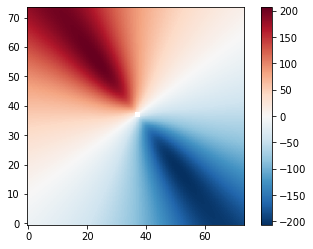

In [7]:
gal_shape = [74,74]
# Initial guesses for minimize
params = [1000,4,0.006,25,incl,ph,37,37]
model = rot_incl_bur_nb(gal_shape,scale_spec,params)
plt.imshow(model,origin='lower',cmap='RdBu_r')
plt.colorbar()

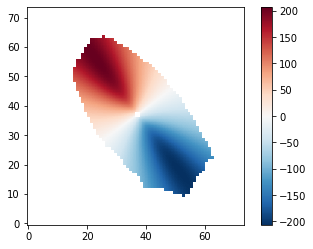

In [8]:
model_mask = ma.array(model, mask = Ha_vel_mask)
plt.imshow(model_mask,origin='lower',cmap='RdBu_r')
plt.colorbar()

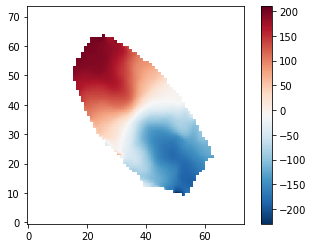

In [9]:
plt.imshow(v_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

/Users/richardzhang/rotation_curve_functions.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  v = A * (Vin ** 2) * ((r / (0.2 * Rd)) ** -1)
/Users/richardzhang/rotation_curve_functions.py:300: RuntimeWarning: invalid value encountered in double_scalars
  vel = np.sqrt(G * (halo_mass * Msun) / (r * 3.08E16))
/Users/richardzhang/Velocity_Map_Functions.py:134: RuntimeWarning: divide by zero encountered in log
  logL = -0.5 * ma.sum((vdata - model) ** 2 * inv_sigma2 - np.log(inv_sigma2))
/Users/richardzhang/rotation_curve_functions.py:47: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v)


---------------------------------------------------
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.71593337e-10,  7.71156076e-13,  2.36420421e-06,
         1.59715672e-07,  2.62284919e-05,  5.29303949e-06,
         1.50329418e-08, -1.24498265e-09,  3.00234001e-08,
         7.28762824e-08],
       [ 3.84085877e-05,  3.36342368e-06, -5.07047441e+00,
         5.66886944e-03, -2.72652374e-05, -1.06579370e+00,
         6.98679566e-04, -6.42122041e-04, -1.18071618e-02,
        -2.19894272e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        

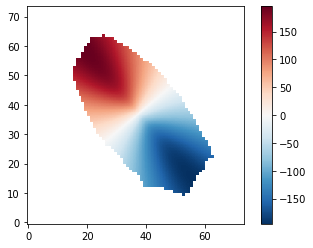

In [10]:
# Initial guesses
param_bounds_iso = [[0, 1],  # Scale Factor [unitless]
                [0.001, 1000],  # Bulge Scale Velocity [km/s]
                [0, 10000],  # Surface Density [Msol/pc^2]
                [0.1, 20],  # Disk radius [kpc]
                [50, 500],  # Velocity at infinity [km/s]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [0,2*np.pi],# Phase angle
                [27,47],#center_x
                [27,47]] #center_y
p0_iso = [0.4,127,1000,4, 150, 25, incl,ph,37,37]
bestfit_iso = minimize(nloglikelihood_iso, p0_iso, args=(scale_spec, gal_shape, v_masked, Ha_vel_ivar),method='Powell',bounds=param_bounds_iso)
print('---------------------------------------------------')
print(bestfit_iso)
# Plotting Isothermal
model_map_iso = rot_incl_iso(gal_shape, scale_spec, bestfit_iso.x)
mask_model_map_iso = ma.array(model_map_iso,mask=Ha_vel_mask)
plt.imshow(mask_model_map_iso,origin='lower',cmap='RdBu_r')
plt.colorbar()

In [11]:
chi_square_iso = np.nansum((v_masked - mask_model_map_iso) ** 2 * Ha_vel_ivar)
chi_square_iso/(1564-8)

39.532758245333056

/Users/richardzhang/rotation_curve_functions.py:321: RuntimeWarning: divide by zero encountered in double_scalars
  return rho0_h / ((r / Rh) * ((1 + (r / Rh)) ** 2))
/Users/richardzhang/rotation_curve_functions.py:334: RuntimeWarning: invalid value encountered in double_scalars
  return 4 * np.pi * (rho_NFW(r, rho0_h, Rh)) * r ** 2
/Users/richardzhang/rotation_curve_functions.py:346: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  halo_mass, m_err = inte.quad(integrand_h_NFW, 0, r, args=(rho0_h, Rh))
/Users/richardzhang/Velocity_Map_Functions.py:158: RuntimeWarning: divide by zero encountered in log
  logL = -0.5 * ma.sum((vdata - model) ** 2 * inv_sigma2 - np.log(inv_sigma2))
/Users/richardzhang/rotation_curve_functions.py:224: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(vel2) / 1000


---------------------------------------------------
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.14139514e-20, -5.81603604e-13,  3.05342175e+00,
         1.17029865e-01, -8.84087299e-05,  5.91320716e-02,
        -4.79054155e-03,  3.89787747e-03,  2.57471513e-02,
         1.31289484e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        

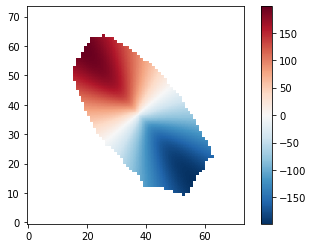

In [13]:
# Initial guesses
param_bounds_NFW = [[0, 1],  # Scale Factor [unitless]
                [0.001, 1000],  # Bulge Scale Velocity [km/s]
                [0, 10000],  # Surface Density [Msol/pc^2]
                [0.1, 20],  # Disk radius [kpc]
                [0.0001, 0.1],  # Halo density [Msun/pc^2]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [0,2*np.pi],# Phase angle
                [27,47],#center_x
                [27,47]] #center_y
p0_NFW = [0.4,127,1000, 4, 0.006, 25, incl,ph,37,37]
bestfit_NFW = minimize(nloglikelihood_NFW, p0_NFW, args=(scale_spec, gal_shape, v_masked, Ha_vel_ivar),method='Powell',bounds=param_bounds_NFW)
print('---------------------------------------------------')
print(bestfit_NFW)
# Plotting NFW
model_map_NFW = rot_incl_NFW(gal_shape, scale_spec, bestfit_NFW.x)
mask_model_map_NFW= ma.array(model_map_NFW,mask=Ha_vel_mask)
plt.imshow(mask_model_map_NFW,origin='lower',cmap='RdBu_r')
plt.colorbar()

In [14]:
chi_square_NFW = np.nansum((v_masked - mask_model_map_NFW) ** 2 * Ha_vel_ivar)
chi_square_NFW/(1564-8)

39.34976980568666

/Users/richardzhang/Velocity_Map_Functions.py:182: RuntimeWarning: divide by zero encountered in log
  logL = -0.5 * ma.sum((vdata - model) ** 2 * inv_sigma2 - np.log(inv_sigma2))


---------------------------------------------------
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-4.01291538e-20, -4.99125131e-13, -4.04602744e+01,
         1.39022632e-01,  1.12429363e-04,  5.99074211e+00,
         5.89278537e-03,  6.26209123e-03,  4.66576972e-02,
         5.75166327e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        

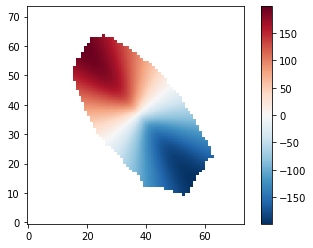

In [15]:
# Initial guesses
param_bounds_bur = [[0, 1],  # Scale Factor [unitless]
                [0.001, 1000],  # Bulge Scale Velocity [km/s]
                [0, 10000],  # Surface Density [Msol/pc^2]
                [0.1, 20],  # Disk radius [kpc]
                [0.0001, 0.1],  # Halo central density[km/s]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [0,2*np.pi],# Phase angle
                [27,47],#center_x
                [27,47]] #center_y
p0_bur = [0.4,127,1000,4,0.006,25,incl,ph,37,37]
bestfit_bur = minimize(nloglikelihood_bur, p0_bur, args=(scale_spec, gal_shape, v_masked, Ha_vel_ivar),method='Powell',bounds=param_bounds_bur)
print('---------------------------------------------------')
print(bestfit_bur)
# Plotting
model_map_bur = rot_incl_bur(gal_shape,scale_spec,bestfit_bur.x)
mask_model_map_bur = ma.array(model_map_bur,mask=Ha_vel_mask)
plt.imshow(mask_model_map_bur,origin='lower',cmap='RdBu_r')
plt.colorbar()

In [16]:
chi_square_bur = np.nansum((v_masked - mask_model_map_bur) ** 2 * Ha_vel_ivar)
chi_square_bur/(1564-8)

39.29133028899738

In [17]:
bestfit_iso.x

array([6.39022904e-05, 1.07005513e-03, 8.00941931e+02, 4.60120477e+00,
       3.74876089e+02, 1.63995316e+01, 1.09293684e+00, 6.96669199e-01,
       3.69710937e+01, 3.73905992e+01])

In [18]:
bestfit_NFW.x

array([6.61069614e-05, 1.04508539e-03, 4.35472232e+02, 4.70224569e+00,
       5.62633152e-03, 2.53930525e+01, 1.09356733e+00, 6.95208977e-01,
       3.69330702e+01, 3.73389439e+01])

In [19]:
bestfit_bur.x

array([6.61069614e-05, 1.12681148e-03, 8.00512180e+02, 4.32982763e+00,
       6.46831447e-03, 4.47171658e+01, 1.09570778e+00, 6.95228388e-01,
       3.69328250e+01, 3.73536927e+01])

# Pipeline for all fitting galaxies

[0.14892007853974257, 0.41832666715147987, 0.29286524616391535, 0.13627008944804014, 0.46886408261217366]
[0.8535863434242611, 0.36003758826844845, 1.021345527988411, 1.3237204164261451, 1.2005955251079776]
[2.621349460964994, 1.7520026010538499, 2.8112690656784687, 2.1792689810695847, 0.6421872084106552]
5
5
5
[44, 49, 59, 24, 41]
[31, 38, 43, 52, 41]
[(72, 72), (72, 72), (74, 74), (74, 74), (74, 74)]
---------------------------------------------------
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 5.33721754e-05,  4.22649854e-03, -8.76071424e-03,
        -1.38390314e-10,  0.00000000e+00,  6.30504088e-04,
         6.23019569e-06,  5.60493343e-07,  9.03813574e-07,
         2.19254331e-07],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        

/Users/richardzhang/rotation_curve_functions.py:346: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  halo_mass, m_err = inte.quad(integrand_h_NFW, 0, r, args=(rho0_h, Rh))
/Users/richardzhang/rotation_curve_functions.py:346: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  halo_mass, m_err = inte.quad(integrand_h_NFW, 0, r, args=(rho0_h, Rh))
/Users/richardzhang/rotation_curve_functions.py:346: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

---------------------------------------------------
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        

/Users/richardzhang/rotation_curve_functions.py:428: RuntimeWarning: invalid value encountered in double_scalars
  vel = np.sqrt(G * halo_mass_kg / (r * 3.0857E16))
/Users/richardzhang/Velocity_Map_Functions.py:182: RuntimeWarning: divide by zero encountered in log
  logL = -0.5 * ma.sum((vdata - model) ** 2 * inv_sigma2 - np.log(inv_sigma2))


---------------------------------------------------
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        

/Users/richardzhang/rotation_curve_functions.py:428: RuntimeWarning: invalid value encountered in sqrt
  vel = np.sqrt(G * halo_mass_kg / (r * 3.0857E16))


---------------------------------------------------
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        

/Users/richardzhang/rotation_curve_functions.py:407: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  halo_mass, m_err = inte.quad(integrand_h_Burket, 0, r, args=(rho0_h, Rh))


---------------------------------------------------
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        

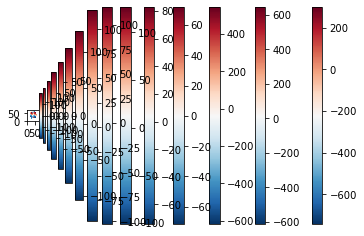

In [102]:
# Fitting all 7443 galaxies
all_galaxies = ['7443-12701','7443-12702','7443-12703','7443-12704','7443-12705']

# Relevant properties
data_cube = []
vmap_n = []
ivar_n = []
mask_n = []
scale_n = []
incl_n = []
ph_n = []
center_x_n = []
center_y_n = []
gshape_n = []

for galaxy_ID in all_galaxies:
    plate,IFU = galaxy_ID.split('-')
    # Obtain redshift
    for i in range(len(DTable2)):
        if DTable2['MaNGA_plate'][i] == int(plate) and DTable2['MaNGA_IFU'][i] == int(IFU):
            redshift = z[i]
            velocity = redshift * c
            distance = (velocity/H_0)*1E3
            scale = 0.5*(distance)/206265
            scale_n.append(scale)
            
    # Obtain inclination
    incl = 0
    for i in range(len(DTable1)):
        if DTable1['MaNGA_plate'][i] == int(plate) and DTable1['MaNGA_IFU'][i] == int(IFU):
            incl = np.arccos(rat[i])
            incl_n.append(incl)
            
    # Obtain phi
    ph = 0
    for i in range(len(DTable1)):
        if DTable1['MaNGA_plate'][i] == int(plate) and DTable1['MaNGA_IFU'][i] == int(IFU):
            ph = phi[i]*np.pi/180
            ph_n.append(ph)
            
    # Obtaining Data Cubes
    cube = fits.open('manga-'+galaxy_ID+'-MAPS-HYB10-GAU-MILESHC.fits.gz')
    r_band = cube['SPX_MFLUX'].data
    Ha_vel = cube['EMLINE_GVEL'].data[18]
    Ha_vel_ivar = cube['EMLINE_GVEL_IVAR'].data[18]
    Ha_vel_mask = cube['EMLINE_GVEL_MASK'].data[18]
    vmasked = ma.array(Ha_vel, mask = Ha_vel_mask)
    gshape = vmasked.shape
    # Finding the center
    center_guess = np.unravel_index(ma.argmin(np.abs(vmasked), axis=None), vmasked.shape)
    x_center_guess = center_guess[0]
    y_center_guess = center_guess[1]
    vmap_n.append(vmasked)
    ivar_n.append(Ha_vel_ivar)
    mask_n.append(Ha_vel_mask)
    center_x_n.append(x_center_guess)
    center_y_n.append(y_center_guess)
    gshape_n.append(gshape)
    cube.close()
    
print(scale_n)
print(incl_n)
print(ph_n)
print(len(vmap_n))
print(len(ivar_n))
print(len(mask_n))
print(center_x_n)
print(center_y_n)
print(gshape_n)

Isothermal_fits = []
NFW_fits = []
Burket_fits = []

# Fitting
for i in range(len(all_galaxies)):
    # Isothermal
    bounds_iso = [[0, 1],  # Scale Factor [unitless]
                [0.001, 1000],  # Bulge Scale Velocity [km/s]
                [0, 10000],  # Surface Density [Msol/pc^2]
                [0.1, 20],  # Disk radius [kpc]
                [50, 500],  # Velocity at infinity [km/s]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [0,2*np.pi],# Phase angle
                [27,47],#center_x
                [27,47]] #center_y
    ig_iso = [0.4,127,1000,4,150,25,incl,ph,37,37]
    bestfit_iso = minimize(nloglikelihood_iso, ig_iso, args=(scale_n[i], gshape_n[i], vmap_n[i], ivar_n[i]),method='Powell',bounds=bounds_iso)
    print('---------------------------------------------------')
    print(bestfit_iso)
    Isothermal_fits.append(bestfit_iso)
    # Plotting Isothermal
    vmap_iso = rot_incl_iso(gshape_n[i], scale_n[i], bestfit_iso.x)
    mask_vmap_iso = ma.array(vmap_iso,mask=mask_n[i])
    plt.imshow(mask_vmap_iso,origin='lower',cmap='RdBu_r')
    plt.colorbar()
    
    # NFW
    bounds_NFW = [[0, 1],  # Scale Factor [unitless]
                [0.001, 1000],  # Bulge Scale Velocity [km/s]
                [0, 10000],  # Surface Density [Msol/pc^2]
                [0.1, 20],  # Disk radius [kpc]
                [0.0001, 0.1],  # Halo density [Msun/pc^2]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [0,2*np.pi],# Phase angle
                [27,47],#center_x
                [27,47]] #center_y
    ig_NFW = [0.4,127,1000,4,0.006,25,incl,ph,37,37]
    bestfit_NFW = minimize(nloglikelihood_NFW, ig_NFW, args=(scale_n[i], gshape_n[i], vmap_n[i], ivar_n[i]),method='Powell',bounds=bounds_NFW)
    print('---------------------------------------------------')
    print(bestfit_NFW)
    NFW_fits.append(bestfit_NFW)
    # Plotting NFW
    vmap_NFW = rot_incl_NFW(gshape_n[i], scale_n[i], bestfit_NFW.x)
    mask_vmap_NFW = ma.array(vmap_NFW,mask=mask_n[i])
    plt.imshow(mask_vmap_NFW,origin='lower',cmap='RdBu_r')
    plt.colorbar()
    
    # Burket
    bounds_bur = [[0, 1],  # Scale Factor [unitless]
                [0.001, 1000],  # Bulge Scale Velocity [km/s]
                [0, 10000],  # Surface Density [Msol/pc^2]
                [0.1, 20],  # Disk radius [kpc]
                [0.0001, 0.1],  # Halo central density[km/s]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [0,2*np.pi],# Phase angle
                [27,47],#center_x
                [27,47]] #center_y
    ig_bur = [0.4,127,1000,4,0.006,25,incl,ph,37,37]
    bestfit_bur = minimize(nloglikelihood_bur, ig_bur, args=(scale_n[i], gshape_n[i], vmap_n[i], ivar_n[i]),method='Powell',bounds=bounds_bur)
    print('---------------------------------------------------')
    print(bestfit_bur)
    Burket_fits.append(bestfit_bur)
    # Plotting NFW
    vmap_bur = rot_incl_bur(gshape_n[i], scale_n[i], bestfit_bur.x)
    mask_vmap_bur = ma.array(vmap_bur,mask=mask_n[i])
    plt.imshow(mask_vmap_bur,origin='lower',cmap='RdBu_r')
    plt.colorbar()

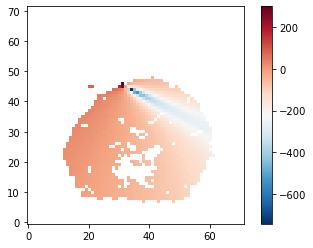

In [199]:
vmap_1 = rot_incl_iso(gshape_n[0],scale_n[0],Isothermal_fits[0].x)
vmap_1_masked = ma.array(vmap_1, mask = mask_n[0])
plt.imshow(vmap_1_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

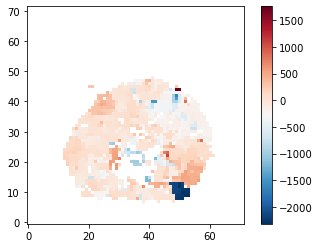

In [200]:
plt.imshow(vmap_n[0],origin='lower',cmap='RdBu_r')
plt.colorbar()

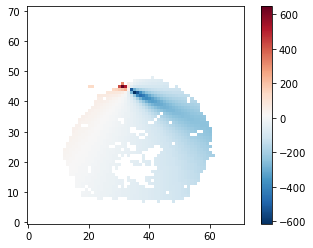

In [201]:
vmap_2 = rot_incl_NFW(gshape_n[0],scale_n[0],NFW_fits[0].x)
vmap_2_masked = ma.array(vmap_2, mask = mask_n[0])
plt.imshow(vmap_2_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

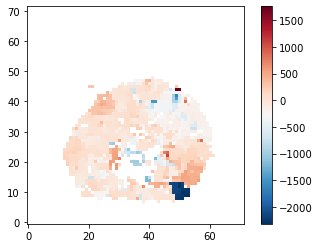

In [202]:
plt.imshow(vmap_n[0],origin='lower',cmap='RdBu_r')
plt.colorbar()

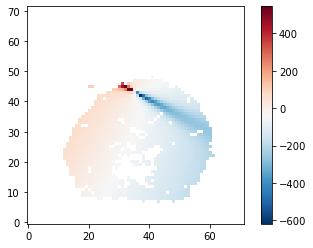

In [203]:
vmap_3 = rot_incl_bur(gshape_n[0],scale_n[0],Burket_fits[0].x)
vmap_3_masked = ma.array(vmap_3, mask = mask_n[0])
plt.imshow(vmap_3_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

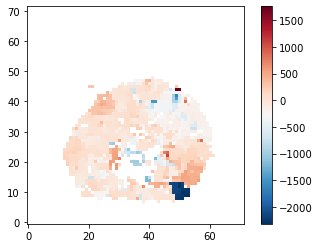

In [204]:
plt.imshow(vmap_n[0],origin='lower',cmap='RdBu_r')
plt.colorbar()

In [205]:
vmap_1.shape[0]*vmap_1.shape[1] - np.sum(vmap_1_masked.mask)

1391

In [206]:
chi_square_1 = np.nansum((vmap_n[0] - vmap_1_masked) ** 2 * ivar_n[0])
chi_square_1/(1391-8)

377.41160678290464

In [207]:
chi_square_2 = np.nansum((vmap_n[0] - vmap_2_masked) ** 2 * ivar_n[0])
chi_square_2/(1391-8)

377.7062199907991

In [208]:
chi_square_3 = np.nansum((vmap_n[0] - vmap_3_masked) ** 2 * ivar_n[0])
chi_square_3/(1391-8)

372.63725664750945

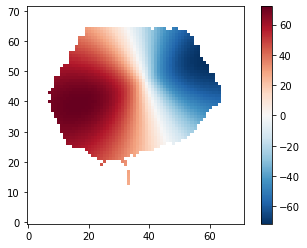

In [209]:
vmap_4 = rot_incl_iso(gshape_n[1],scale_n[1],Isothermal_fits[1].x)
vmap_4_masked = ma.array(vmap_4, mask = mask_n[1])
plt.imshow(vmap_4_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

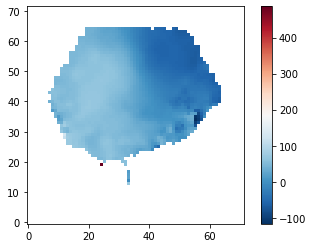

In [210]:
plt.imshow(vmap_n[1],origin='lower',cmap='RdBu_r')
plt.colorbar()

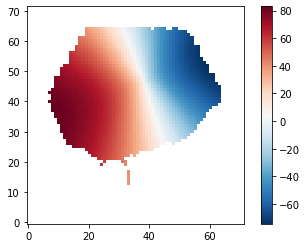

In [211]:
vmap_5 = rot_incl_NFW(gshape_n[1],scale_n[1],NFW_fits[1].x)
vmap_5_masked = ma.array(vmap_5, mask = mask_n[1])
plt.imshow(vmap_5_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

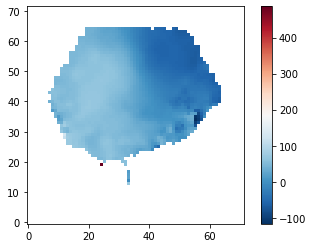

In [212]:
plt.imshow(vmap_n[1],origin='lower',cmap='RdBu_r')
plt.colorbar()

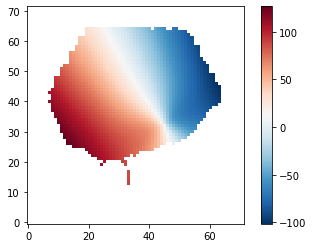

In [213]:
vmap_6 = rot_incl_bur(gshape_n[1],scale_n[1],Burket_fits[1].x)
vmap_6_masked = ma.array(vmap_6, mask = mask_n[1])
plt.imshow(vmap_6_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

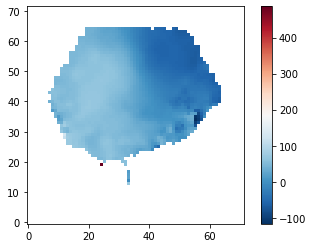

In [214]:
plt.imshow(vmap_n[1],origin='lower',cmap='RdBu_r')
plt.colorbar()

In [215]:
vmap_4.shape[0]*vmap_4.shape[1] - np.sum(vmap_4_masked.mask)

1908

In [216]:
chi_square_4 = np.nansum((vmap_n[1] - vmap_4_masked) ** 2 * ivar_n[1])
chi_square_4/(1908-8)

35.16973048201071

In [217]:
chi_square_5 = np.nansum((vmap_n[1] - vmap_5_masked) ** 2 * ivar_n[1])
chi_square_5/(1908-8)

35.468894636335826

In [218]:
chi_square_6 = np.nansum((vmap_n[1] - vmap_6_masked) ** 2 * ivar_n[1])
chi_square_6/(1908-8)

118.84246555832125

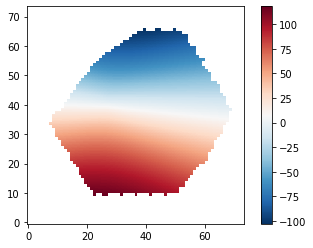

In [219]:
vmap_7 = rot_incl_iso(gshape_n[2],scale_n[2],Isothermal_fits[2].x)
vmap_7_masked = ma.array(vmap_7, mask = mask_n[2])
plt.imshow(vmap_7_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

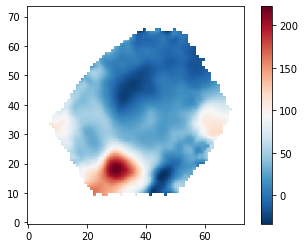

In [220]:
plt.imshow(vmap_n[2],origin='lower',cmap='RdBu_r')
plt.colorbar()

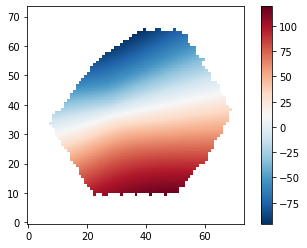

In [221]:
vmap_8 = rot_incl_NFW(gshape_n[2],scale_n[2],NFW_fits[2].x)
vmap_8_masked = ma.array(vmap_8, mask = mask_n[2])
plt.imshow(vmap_8_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

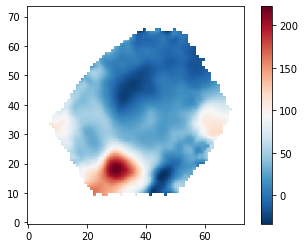

In [222]:
plt.imshow(vmap_n[2],origin='lower',cmap='RdBu_r')
plt.colorbar()

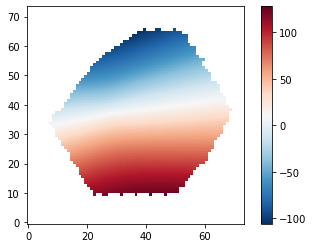

In [223]:
vmap_9 = rot_incl_bur(gshape_n[2],scale_n[2],Burket_fits[2].x)
vmap_9_masked = ma.array(vmap_9, mask = mask_n[2])
plt.imshow(vmap_9_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

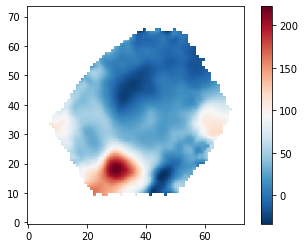

In [224]:
plt.imshow(vmap_n[2],origin='lower',cmap='RdBu_r')
plt.colorbar()

In [225]:
vmap_7.shape[0]*vmap_7.shape[1] - np.sum(vmap_7_masked.mask)

2534

In [226]:
chi_square_7 = np.nansum((vmap_n[2] - vmap_7_masked) ** 2 * ivar_n[2])
chi_square_7/(2534-8)

1786.778264442864

In [227]:
chi_square_8 = np.nansum((vmap_n[2] - vmap_8_masked) ** 2 * ivar_n[2])
chi_square_8/(2534-8)

1497.0472127625005

In [228]:
chi_square_9 = np.nansum((vmap_n[2] - vmap_9_masked) ** 2 * ivar_n[2])
chi_square_9/(2534-8)

1484.1256478904077

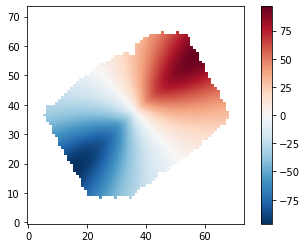

In [229]:
vmap_10 = rot_incl_iso(gshape_n[3],scale_n[3],Isothermal_fits[3].x)
vmap_10_masked = ma.array(vmap_10, mask = mask_n[3])
plt.imshow(vmap_10_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

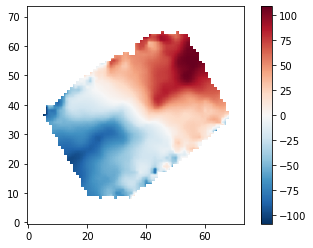

In [230]:
plt.imshow(vmap_n[3],origin='lower',cmap='RdBu_r')
plt.colorbar()

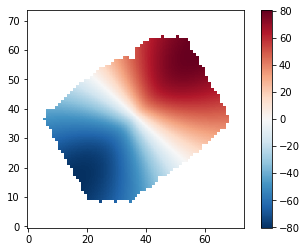

In [231]:
vmap_11 = rot_incl_NFW(gshape_n[3],scale_n[3],NFW_fits[3].x)
vmap_11_masked = ma.array(vmap_11, mask = mask_n[3])
plt.imshow(vmap_11_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

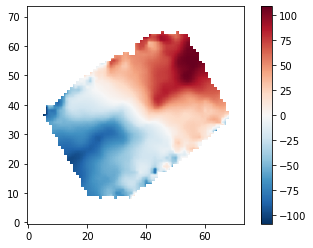

In [232]:
plt.imshow(vmap_n[3],origin='lower',cmap='RdBu_r')
plt.colorbar()

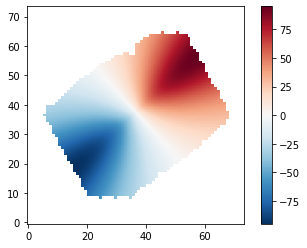

In [233]:
vmap_12 = rot_incl_bur(gshape_n[3],scale_n[3],Burket_fits[3].x)
vmap_12_masked = ma.array(vmap_12, mask = mask_n[3])
plt.imshow(vmap_12_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

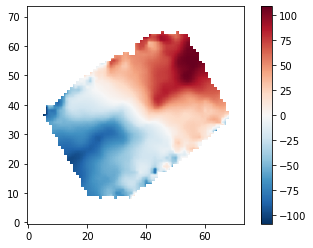

In [234]:
plt.imshow(vmap_n[3],origin='lower',cmap='RdBu_r')
plt.colorbar()

In [235]:
vmap_10.shape[0]*vmap_10.shape[1] - np.sum(vmap_10_masked.mask)

2338

In [236]:
chi_square_10 = np.nansum((vmap_n[3] - vmap_10_masked) ** 2 * ivar_n[3])
chi_square_10/(2338-8)

42.9804335582777

In [237]:
chi_square_11 = np.nansum((vmap_n[3] - vmap_11_masked) ** 2 * ivar_n[3])
chi_square_11/(2338-8)

57.95934318561703

In [238]:
chi_square_12 = np.nansum((vmap_n[3] - vmap_12_masked) ** 2 * ivar_n[3])
chi_square_12/(2338-8)

42.06558708013895

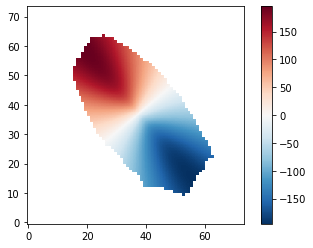

In [239]:
vmap_13 = rot_incl_iso(gshape_n[4],scale_n[4],Isothermal_fits[4].x)
vmap_13_masked = ma.array(vmap_13, mask = mask_n[4])
plt.imshow(vmap_13_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

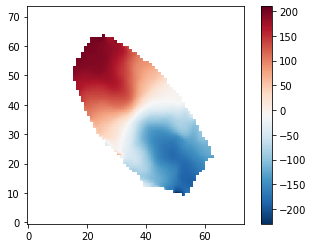

In [240]:
plt.imshow(vmap_n[4],origin='lower',cmap='RdBu_r')
plt.colorbar()

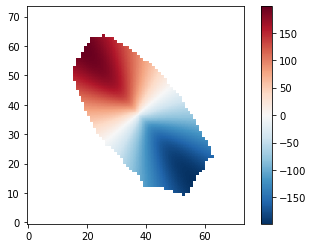

In [241]:
vmap_14 = rot_incl_NFW(gshape_n[4],scale_n[4],NFW_fits[4].x)
vmap_14_masked = ma.array(vmap_14, mask = mask_n[4])
plt.imshow(vmap_14_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

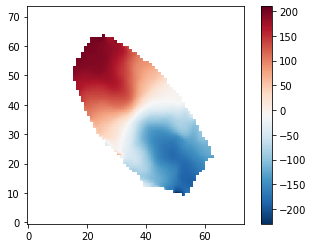

In [242]:
plt.imshow(vmap_n[4],origin='lower',cmap='RdBu_r')
plt.colorbar()

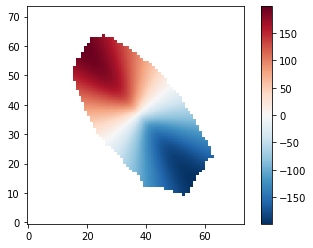

In [243]:
vmap_15 = rot_incl_bur(gshape_n[4],scale_n[4],Burket_fits[4].x)
vmap_15_masked = ma.array(vmap_15, mask = mask_n[4])
plt.imshow(vmap_15_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

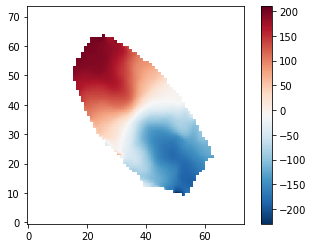

In [244]:
plt.imshow(vmap_n[4],origin='lower',cmap='RdBu_r')
plt.colorbar()

In [245]:
vmap_15.shape[0]*vmap_15.shape[1] - np.sum(vmap_15_masked.mask)

1564

In [246]:
chi_square_13 = np.nansum((vmap_n[4] - vmap_13_masked) ** 2 * ivar_n[4])
chi_square_13/(1564-8)

39.532758245333056

In [247]:
chi_square_14 = np.nansum((vmap_n[4] - vmap_14_masked) ** 2 * ivar_n[4])
chi_square_14/(1564-8)

39.34976980568666

In [248]:
chi_square_15 = np.nansum((vmap_n[4] - vmap_15_masked) ** 2 * ivar_n[4])
chi_square_15/(1564-8)

39.29133028899738